In [110]:
# from tensorflow.keras.models import load_model
import numpy as np
import tensorflow as tf
from neurite_sandbox.tf.models import labels_to_labels
from neurite_sandbox.tf.utils.augment import add_outside_shapes
from neurite.tf.utils.augment import draw_perlin_full

import tensorflow.keras.layers as KL
import voxelmorph as vxm


import argparse
from tensorflow.keras.callbacks import ReduceLROnPlateau
import pathlib
# import surfa as sf
import re
import json
from keras import backend as K
import param_3d
import data
import model_3d
from data_3d import *
import scipy.ndimage as ndimage

import nibabel as nib
from tqdm import tqdm

from utils import *
from help import *

[DEBUG] NiftiArrayIO.load(): no header extensions found!
[DEBUG] NiftiArrayIO.load(): no header extensions found!


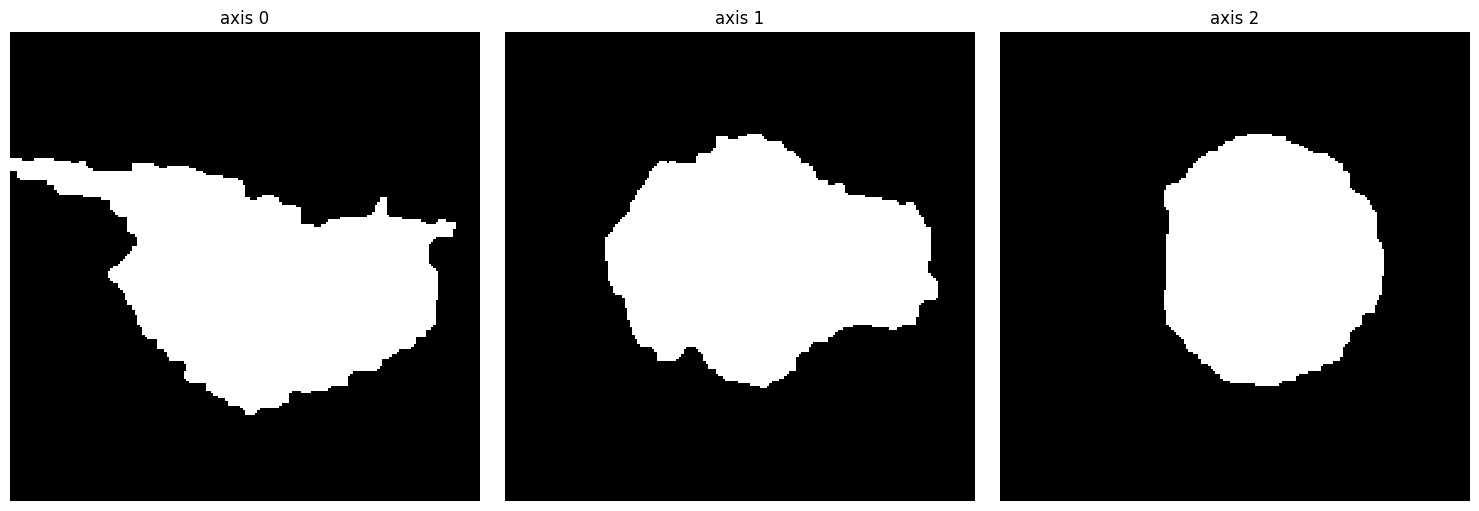

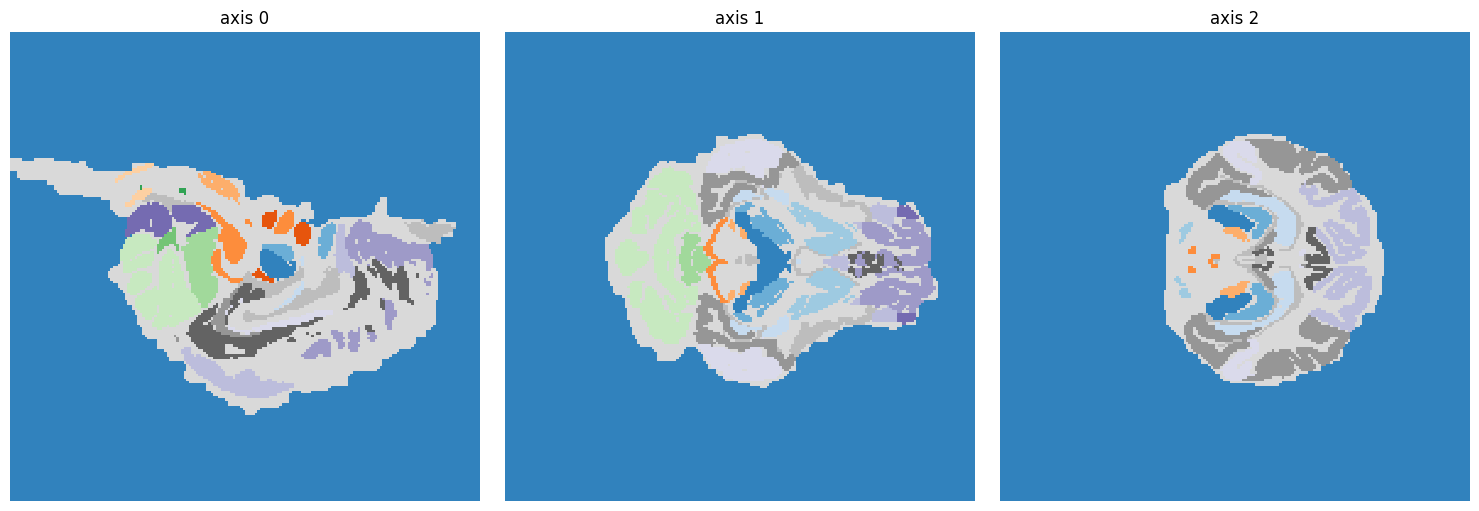

(<Figure size 1500x500 with 3 Axes>,
 [array([<AxesSubplot:title={'center':'axis 0'}>,
         <AxesSubplot:title={'center':'axis 1'}>,
         <AxesSubplot:title={'center':'axis 2'}>], dtype=object)])

In [111]:
# folder_path = "/cbica/home/dadashkj/neuroconnlab_pig_data/dwi_PigAnatomical/7646/anat"
from scipy.ndimage import binary_fill_holes
structure = np.ones((3, 3, 3), dtype=bool)

def fill_holes_per_class(mask, labels=None):
    filled_mask = np.zeros_like(mask)
    if labels is None:
        labels = np.unique(mask)
        labels = labels[labels != 0]  # skip background

    for label in labels:
        class_mask = (mask == label)
        filled_class = ndi.binary_fill_holes(class_mask)
        filled_mask[filled_class] = label

    return filled_mask

folder_path = "/gpfs/fs001/cbica/home/dadashkj/upenn_pigAnatomical/template/"
# folder_path="/gpfs/fs001/cbica/home/afreens/PIG_TBI/ATLASES/"

from scipy.ndimage import zoom

# geom_data = sf.load_volume(os.path.join(folder_path, 'anat.nii.gz')).geom
pig_histo = sf.load_volume(os.path.join(folder_path, 'anat_brain.nii.gz')).reshape([192, 192, 192]).data
pig_seg = sf.load_volume(os.path.join(folder_path, 'anat_brain_atlas102.nii.gz')).reshape([192, 192, 192]).data
# pig_seg = unify_pig_brain_labels(pig_seg, 'atlas/pig_brain_old_and_unified_labels.csv')
# pig_seg = sf.Volume(zoom(pig_seg.data, 0.5, order=1)).reshape([192, 192, 192]).data

brain_mask = pig_histo>0
brain_mask = binary_fill_holes(brain_mask)

# # csf_mask = brain_mask & (pig_seg == 0)

# # # 3. Create a new filled segmentation
# pig_seg_filled = pig_seg.copy()
# print(np.sum(pig_seg_filled))
# # pig_seg_filled[csf_mask] = 102
# print(np.sum(pig_seg_filled))

# # sigma = 0.9  # Adjust sigma for desired smoothing effect
# # pig_seg_filled = fill_holes_per_class(pig_seg_filled)
# # pig_seg_filled = gaussian_filter(pig_seg_filled, sigma=sigma)

ne.plot.volume3D(brain_mask)

ne.plot.volume3D(pig_seg,cmaps=['tab20c'])
# nib.save(nib.Nifti1Image(pig_seg_filled.astype(np.int32), np.eye(4)),os.path.join(folder_path, 'sadia.nii.gz'))


In [3]:
np.unique(pig_seg)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102],
      dtype=int32)

2025-04-29 19:51:06.661428: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11419 MB memory:  -> device: 0, name: TITAN Xp COLLECTORS EDITION, pci bus id: 0000:04:00.0, compute capability: 6.1
2025-04-29 19:51:09.045256: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201


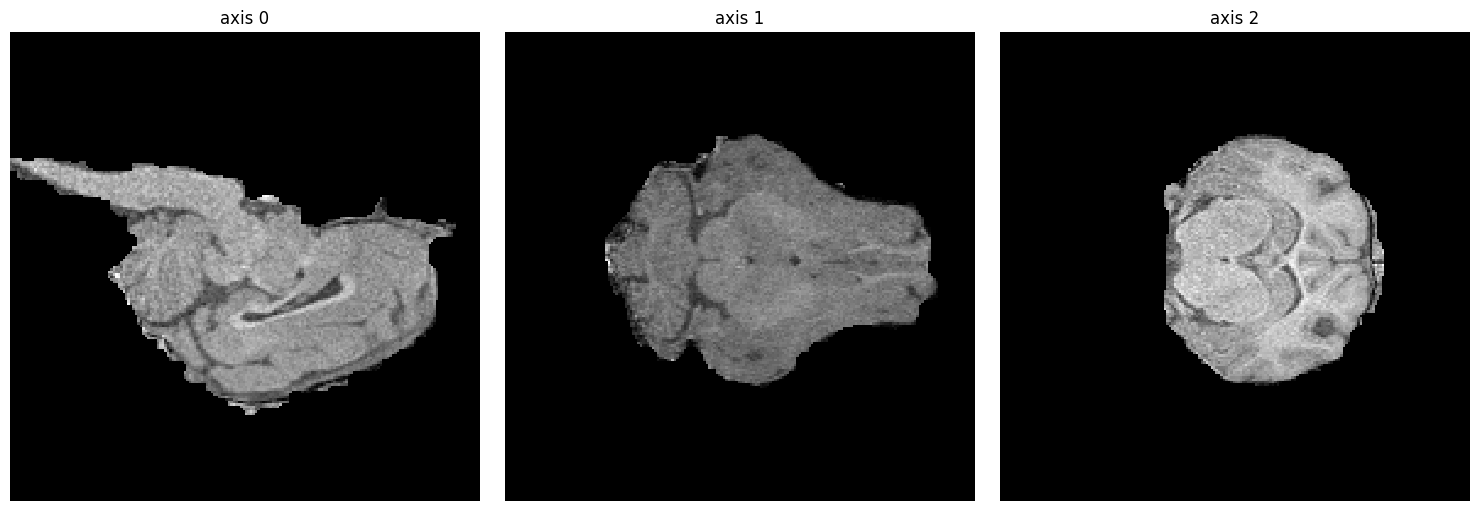

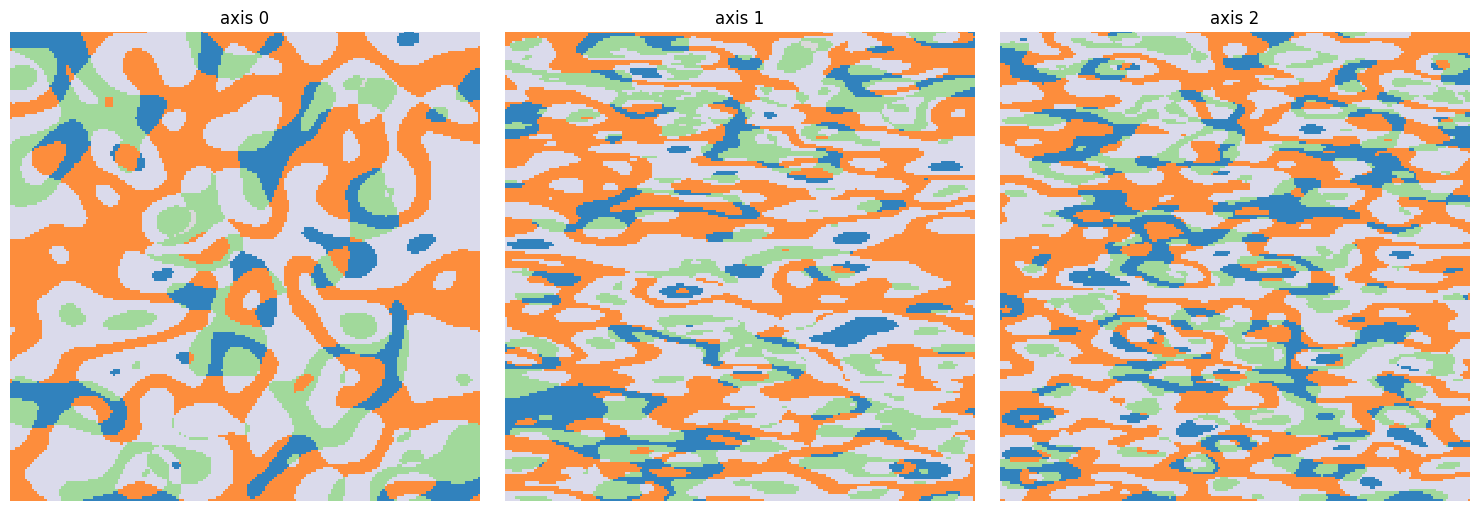

(<Figure size 1500x500 with 3 Axes>,
 [array([<AxesSubplot:title={'center':'axis 0'}>,
         <AxesSubplot:title={'center':'axis 1'}>,
         <AxesSubplot:title={'center':'axis 2'}>], dtype=object)])

In [4]:
import numpy as np
import os
from sklearn.mixture import GaussianMixture
from scipy.ndimage import gaussian_filter
# Smooth the anatomy using Gaussian filter (with a chosen sigma)
pig_brain = pig_histo
shapes = draw_shapes_easy(shape = (192,)*3)   

brain_data = pig_brain.flatten().reshape(-1, 1)
non_brain_data = shapes.numpy().flatten().reshape(-1, 1)

ne.plot.volume3D(brain_data.reshape((192,192,192)))
ne.plot.volume3D(non_brain_data.reshape((192,192,192)),cmaps=['tab20c'])
# ne.plot.volume3D(smoothed_anat)

In [5]:
# k1 = 6
# k2=10

# def make_smooth(label_map):
#     smoothed_labels = gaussian_filter(label_map.astype(float), sigma=2)
#     return np.round(smoothed_labels).astype(int)
# # Apply GMM for brain regions (assumes 29 brain regions to be classified)
# # gmm_brain = GaussianMixture(n_components=k1, random_state=42)
# # gmm_brain.fit(brain_data)  # Fit GMM on the brain data

# # Apply GMM for non-brain regions (background and other tissues)
# gmm_non_brain = GaussianMixture(n_components=k2, random_state=42)  # 0 for background, 30-40 for other tissues
# gmm_non_brain.fit(non_brain_data)  # Fit GMM on the non-brain data

# # Predict the components (labels) for brain and non-brain regions
# # predicted_brain_labels = gmm_brain.predict(brain_data)
# predicted_brain_labels = pig_seg
# predicted_non_brain_labels = gmm_non_brain.predict(non_brain_data)

# predicted_brain_labels = make_smooth(predicted_brain_labels)
# predicted_non_brain_labels = make_smooth(predicted_non_brain_labels)

predicted_brain_labels = pig_seg
predicted_non_brain_labels = non_brain_data.reshape((192,192,192))

# ne.plot.volume3D(predicted_brain_labels,cmaps=['tab20c'])
# ne.plot.volume3D(predicted_non_brain_labels,cmaps=['tab20c'])

In [6]:
num_forground_classes = 102
# predicted_non_brain_labels[pig_brain_mask == 1] = 0
predicted_non_brain_labels = shift_non_zero_elements(predicted_non_brain_labels,num_forground_classes)
predicted_anat_labels = np.where(predicted_brain_labels > 0, predicted_brain_labels, predicted_non_brain_labels)


In [7]:
np.unique(predicted_non_brain_labels)

array([104., 105., 106., 107., 108.], dtype=float32)

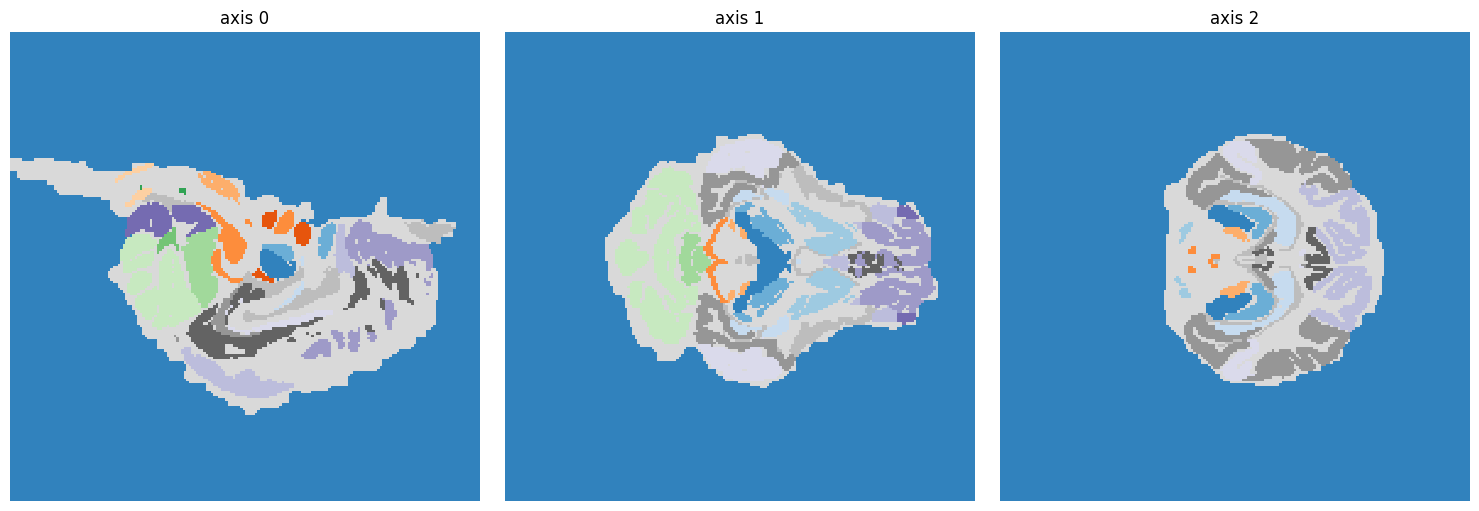

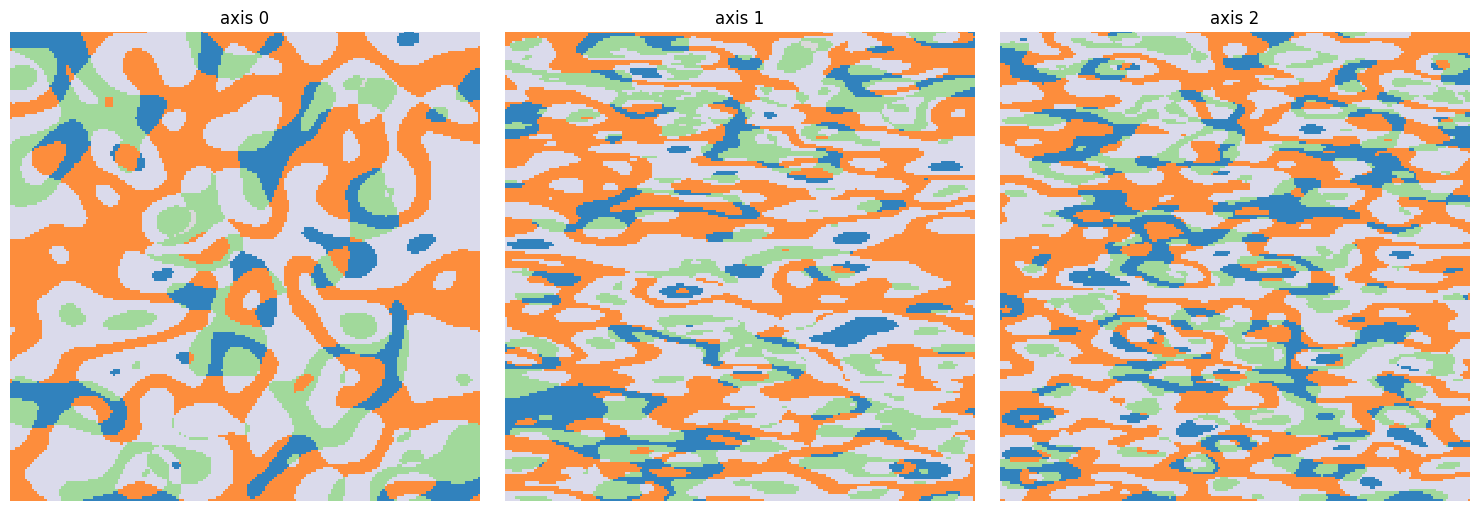

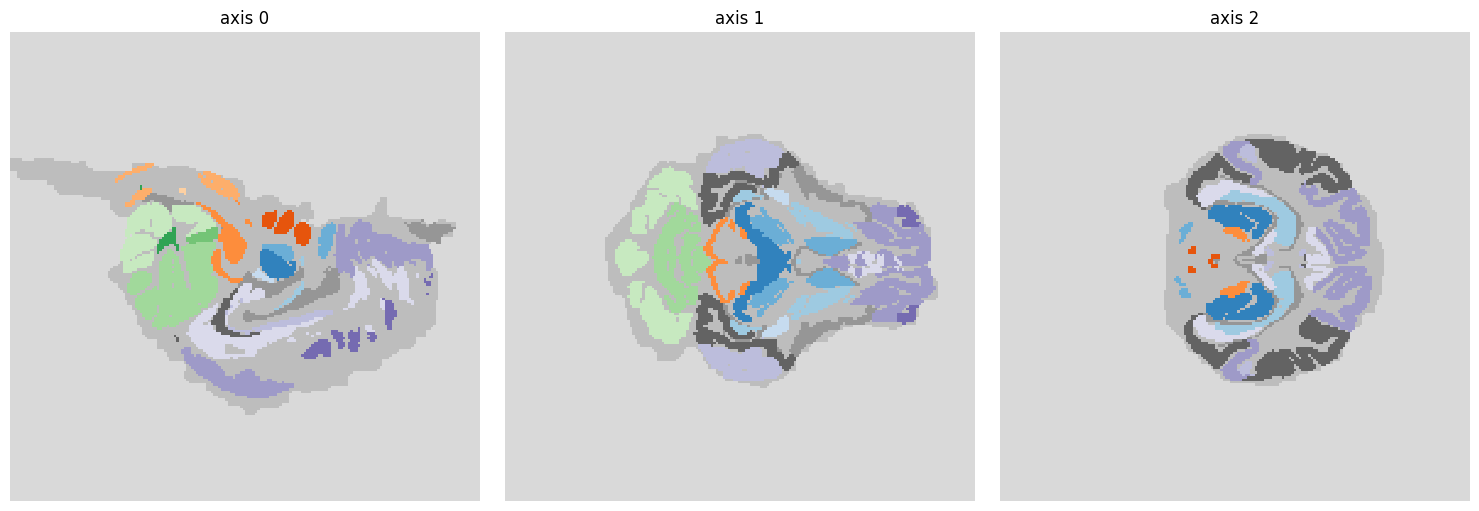

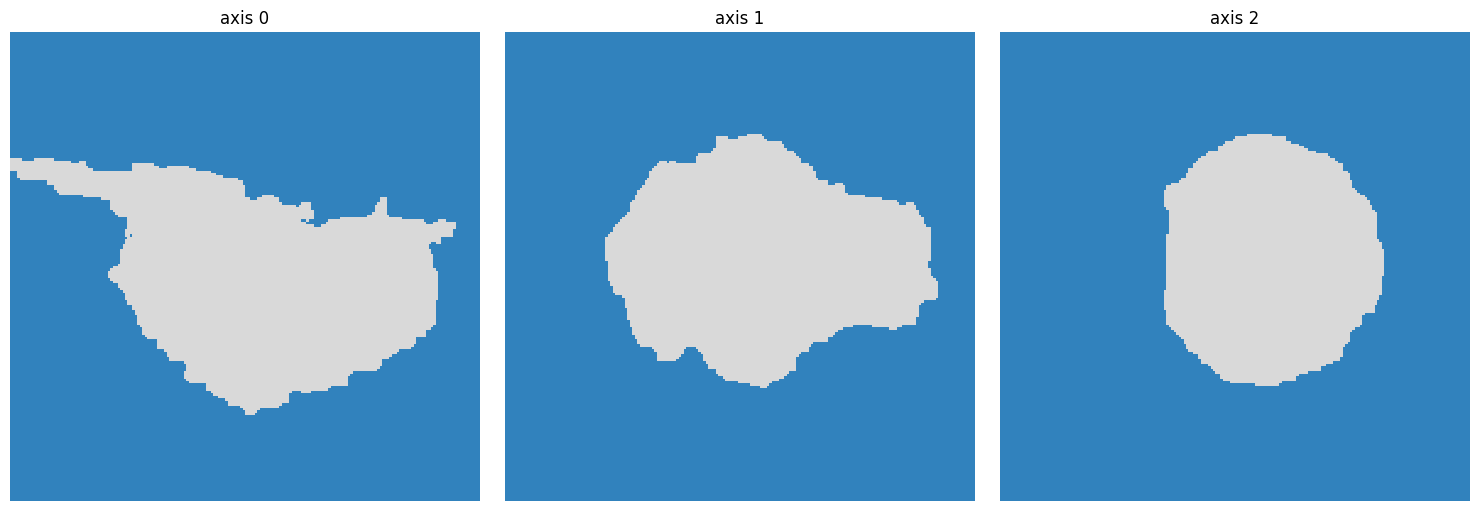

[104. 105. 106. 107. 108.]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102]
[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.
  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.
  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.  84.
  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.  98.
  99. 100. 101. 102. 104. 105. 106. 107. 108.]


In [8]:

zoomed_predicted_anat_labels = sf.Volume(predicted_anat_labels).reshape([param_3d.img_size_192,]*3) # Use order=1 for bilinear interpolation
        
pig_brain_map = [zoomed_predicted_anat_labels]
# ne.plot.volume3D(predicted_non_brain_labels,cmaps=['tab20c'])
# ne.plot.volume3D(predicted_brain_labels,cmaps=['tab20c'])
# ne.plot.volume3D(predicted_anat_labels,cmaps=['tab20c'])
ne.plot.volume3D(predicted_brain_labels,cmaps=['tab20c'])
ne.plot.volume3D(predicted_non_brain_labels,cmaps=['tab20c'])

ne.plot.volume3D(zoomed_predicted_anat_labels,cmaps=['tab20c'])

ne.plot.volume3D(
    (zoomed_predicted_anat_labels > 0) & (zoomed_predicted_anat_labels < 103),
    cmaps=['tab20c']
)

print(np.unique(predicted_non_brain_labels))
print(np.unique(predicted_brain_labels))
print(np.unique(zoomed_predicted_anat_labels))


In [10]:
nib.save(nib.Nifti1Image(zoomed_predicted_anat_labels.astype(np.int32), np.eye(4)), os.path.join("synth_data", 'atlas_fg_bg.nii.gz'))


In [12]:
with open("params_gmm_seg_atlas_192.json", "r") as json_file:
    config = json.load(json_file)
num_forground_classes=102

gen=generator_brain_window_Net(pig_brain_map,param_3d.img_size_192)

model_pig_config = config["pig_48"]
model_pig_config["labels_in"] = {
    label: label for label in range(num_forground_classes)
}


model_shapes_config = config["shapes"]
model_shapes_config["labels_in"] = {label: label for label in [0] + list(range(num_forground_classes + 1, num_forground_classes + 11))}


model_pig_config["in_shape"]=[ param_3d.img_size_192,]*3 
model_shapes_config["in_shape"]=[ param_3d.img_size_192,]*3 

model3_config = config["labels_to_image_model_48"]

all_possible_labels = list(range(0,num_forground_classes+10))  # or use np.unique(pig_seg) if available

model3_config["labels_in"] = {
    label: label for label in all_possible_labels
}

model3_config["labels_out"] = {
    label: label if 1 <= label <= num_forground_classes else 0
    for label in all_possible_labels  # Only up to 250, so output shape = 251
}

model3_config["in_shape"]=[ param_3d.img_size_192,]*3 
model_pig = create_model(model_pig_config)
model_shapes = create_model(model_shapes_config)
shapes = draw_shapes_easy(shape = (param_3d.img_size_192,)*3)   

labels_to_image_model = create_model(model3_config)


fragment = next(gen)
# _, fg = model_pig(fragment)


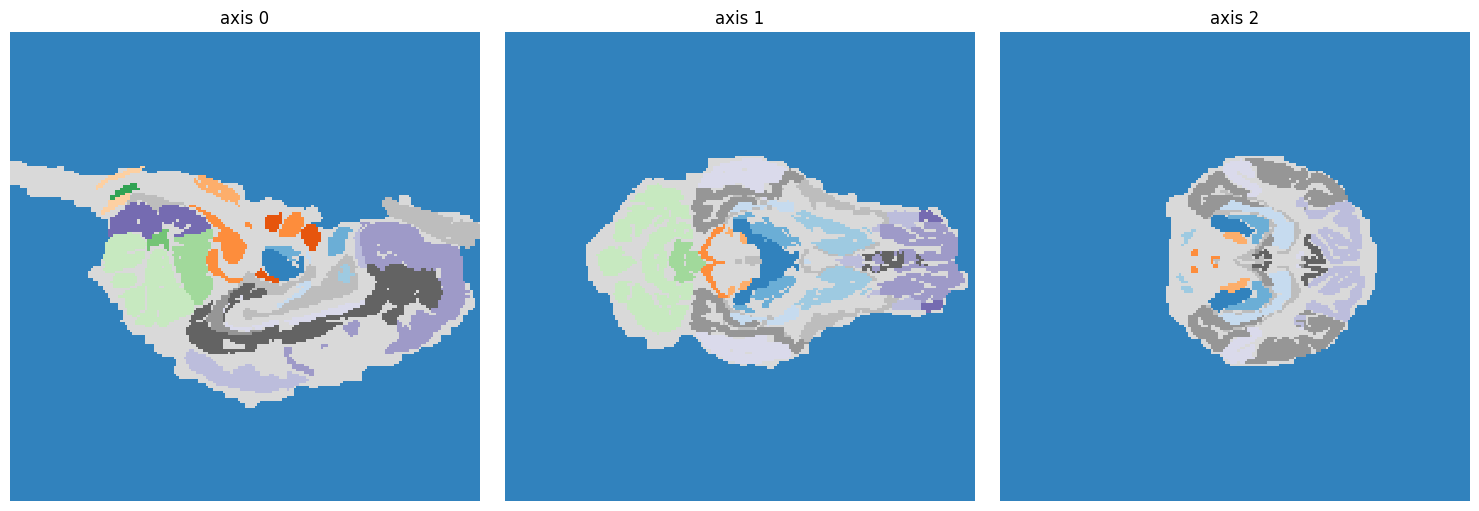

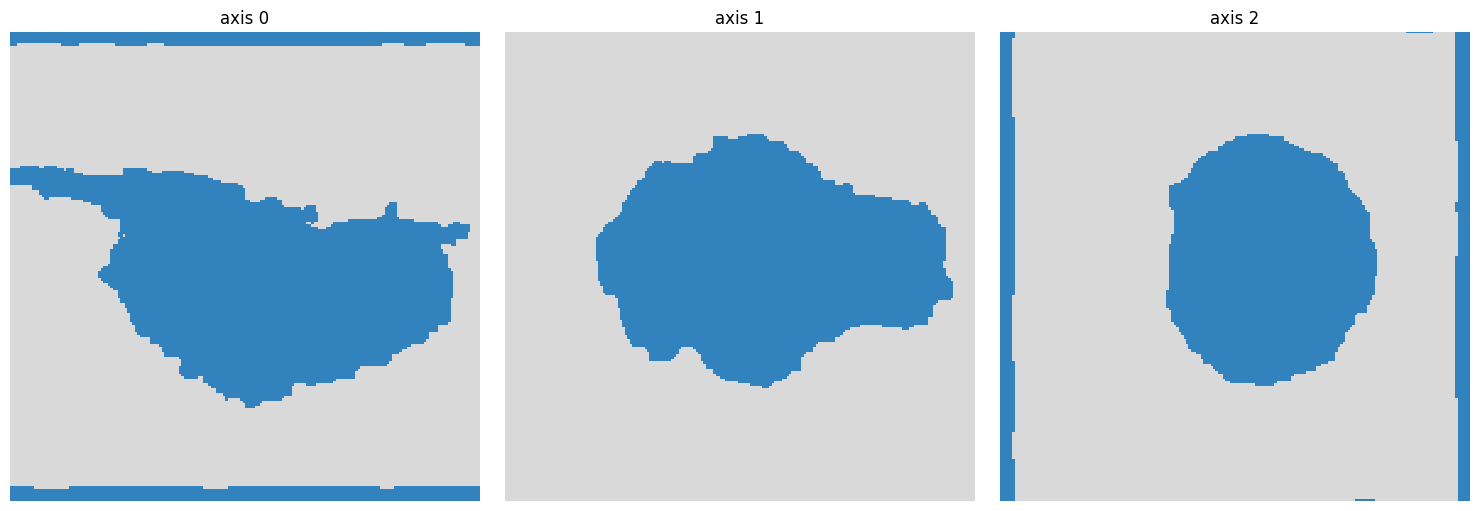

(<Figure size 1500x500 with 3 Axes>,
 [array([<AxesSubplot:title={'center':'axis 0'}>,
         <AxesSubplot:title={'center':'axis 1'}>,
         <AxesSubplot:title={'center':'axis 2'}>], dtype=object)])

In [13]:
a = fragment[0, ...,0] 
fg_mask = (a >= 1) & (a <= num_forground_classes)  

fragment_brain = tf.where(fg_mask, a, 0)
# fragment_brain = tf.where(fg_mask, 1, 0) 
_, fg = model_pig(fragment_brain[None,...,None])
ne.plot.volume3D(fg[0,...,0],cmaps=['tab20c'])

a = fragment[0, ...,0] 
bg_mask = (a > num_forground_classes) | (a == 0)
fragment_bg = tf.where(bg_mask, a, 0)
_, bg = model_shapes(fragment_bg[None,...,None])
ne.plot.volume3D(bg[0,...,0],cmaps=['tab20c'])

In [25]:
_, fg = model_pig(fragment)

shapes = draw_shapes_easy(shape = (param_3d.img_size_192,)*3,num_label=10)

shapes = tf.squeeze(shapes)
shapes = tf.cast(shapes, tf.int32)
shapes = shift_non_zero_elements(shapes,num_forground_classes)
_ , bg = model_shapes(shapes[None,...,None])
# result = fg[0,...,0] +bg[0,...,0] * tf.cast(fg[0,...,0] == 0,tf.int32)

# result = result[None,...,None]

def mask_bg_near_fg(fg, bg, dilation_iter=4):
    d_iter = tf.random.uniform([], minval=1, maxval=dilation_iter + 1, dtype=tf.int32)
    k = 2 * d_iter + 1
    fg_mask = tf.cast(fg[0, ..., 0] > 0, tf.float32)
    fg_mask = tf.reshape(fg_mask, [1, *fg_mask.shape, 1])
    fg_mask = tf.nn.max_pool3d(fg_mask, ksize=[1, k, k, k, 1], strides=[1, 1, 1, 1, 1], padding='SAME')
    fg_mask = tf.squeeze(fg_mask > 0)

    bg_masked = tf.where(fg_mask, bg[0, ..., 0], tf.zeros_like(bg[0, ..., 0]))
    result = tf.where(fg[0, ..., 0] > 0, fg[0, ..., 0], bg_masked)
    return result

result = mask_bg_near_fg(fg, bg, dilation_iter=8)

result = result[None,...,None]

In [15]:
gpus = tf.config.list_physical_devices('GPU')
print("Num GPUs Available:", len(gpus))
print("GPUs:", gpus)

Num GPUs Available: 1
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


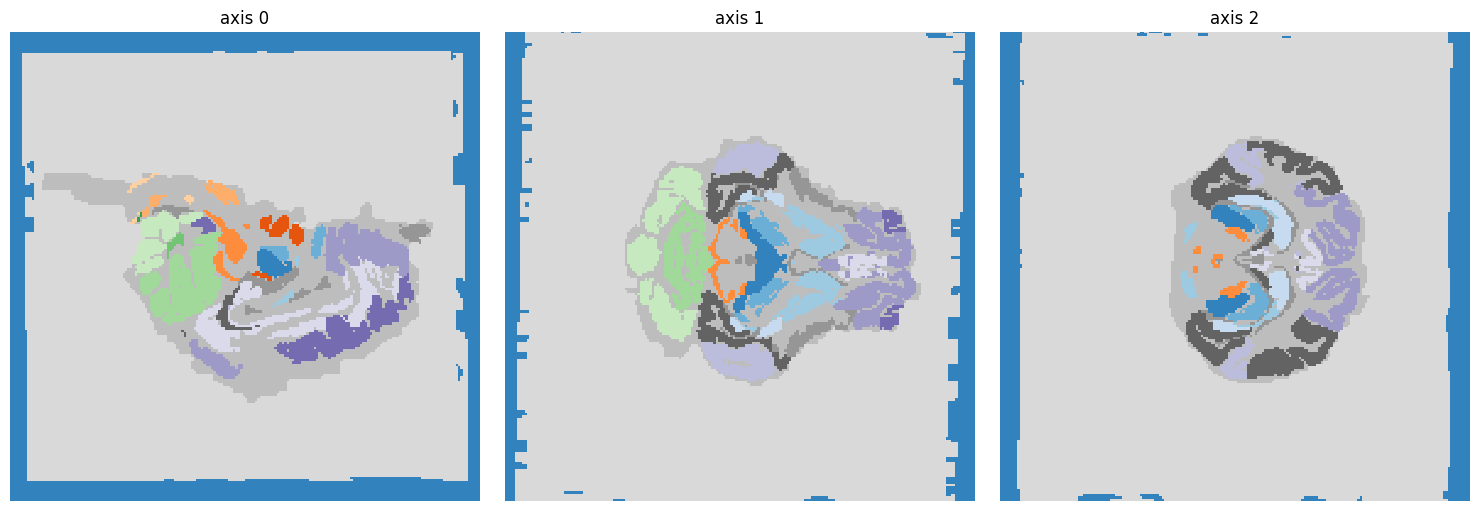

(<Figure size 1500x500 with 3 Axes>,
 [array([<AxesSubplot:title={'center':'axis 0'}>,
         <AxesSubplot:title={'center':'axis 1'}>,
         <AxesSubplot:title={'center':'axis 2'}>], dtype=object)])

In [26]:
# result = fg[0,...,0] + bg[0,...,0] * tf.cast(fg[0,...,0] == 0,tf.int32)
ne.plot.volume3D(result[0,...,0],cmaps=['tab20c'])


In [28]:
result.shape

TensorShape([1, 192, 192, 192, 1])

(1, 192, 192, 192, 1)
(192, 192, 192) 47680540 102


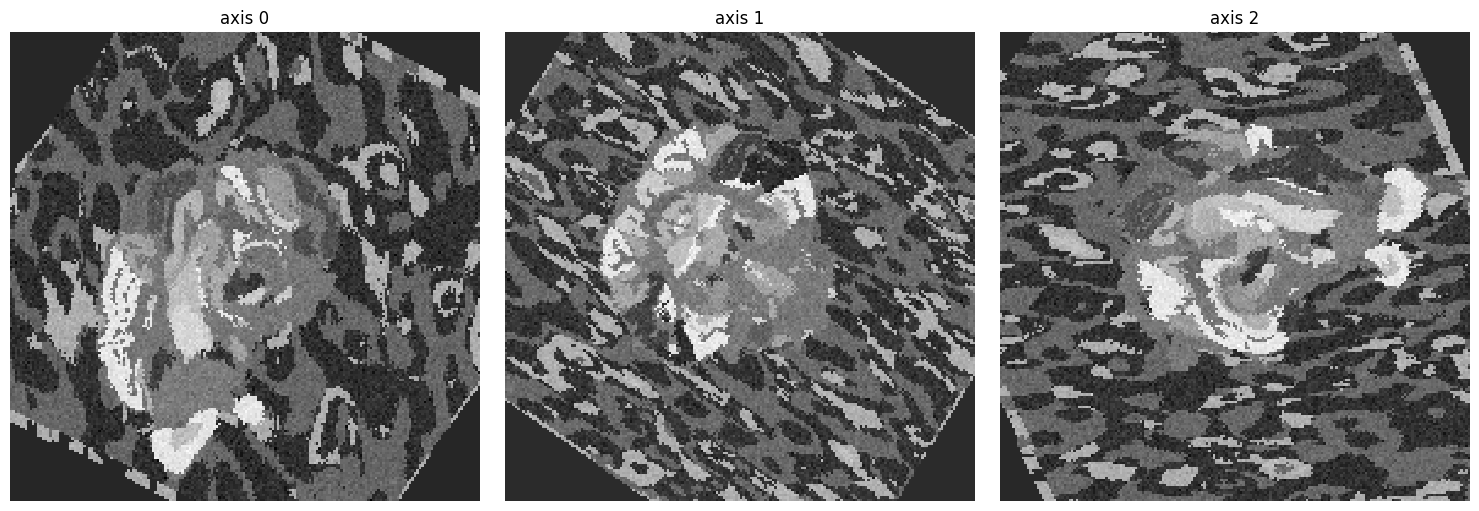

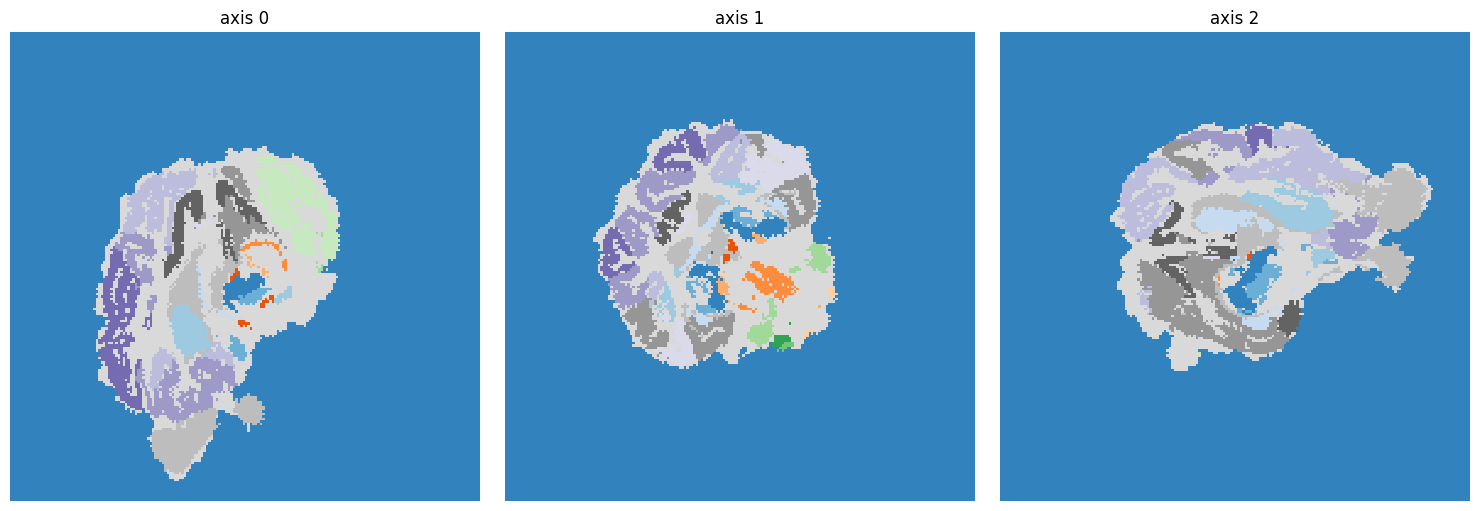

(1, 192, 192, 192, 1)
(192, 192, 192) 45049933 102


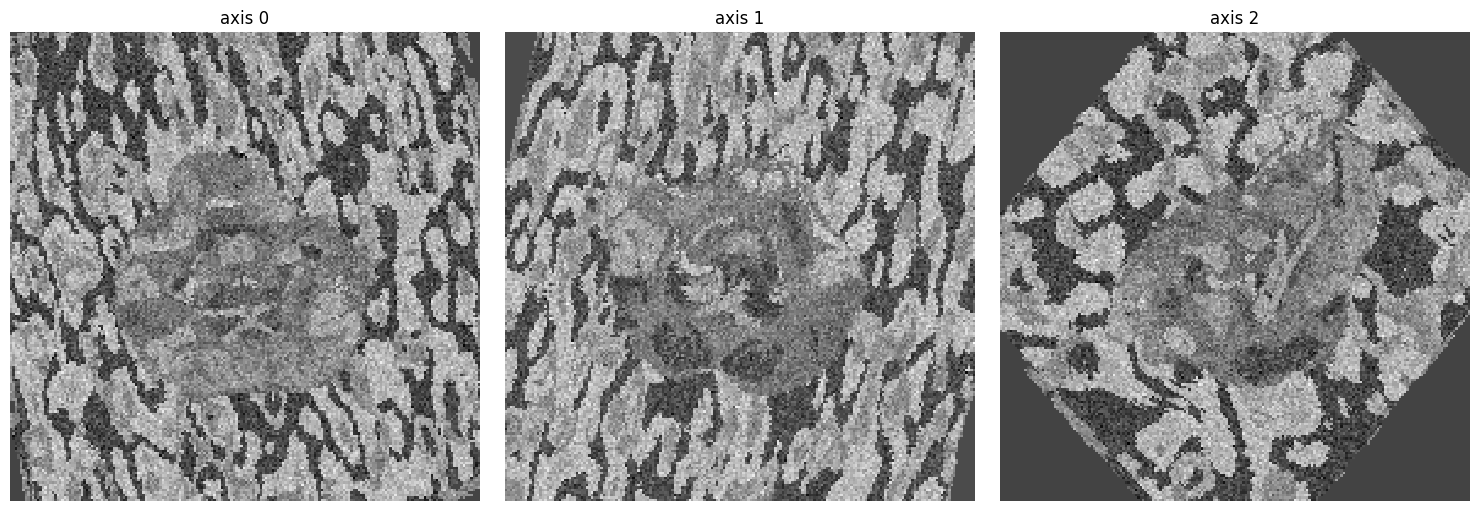

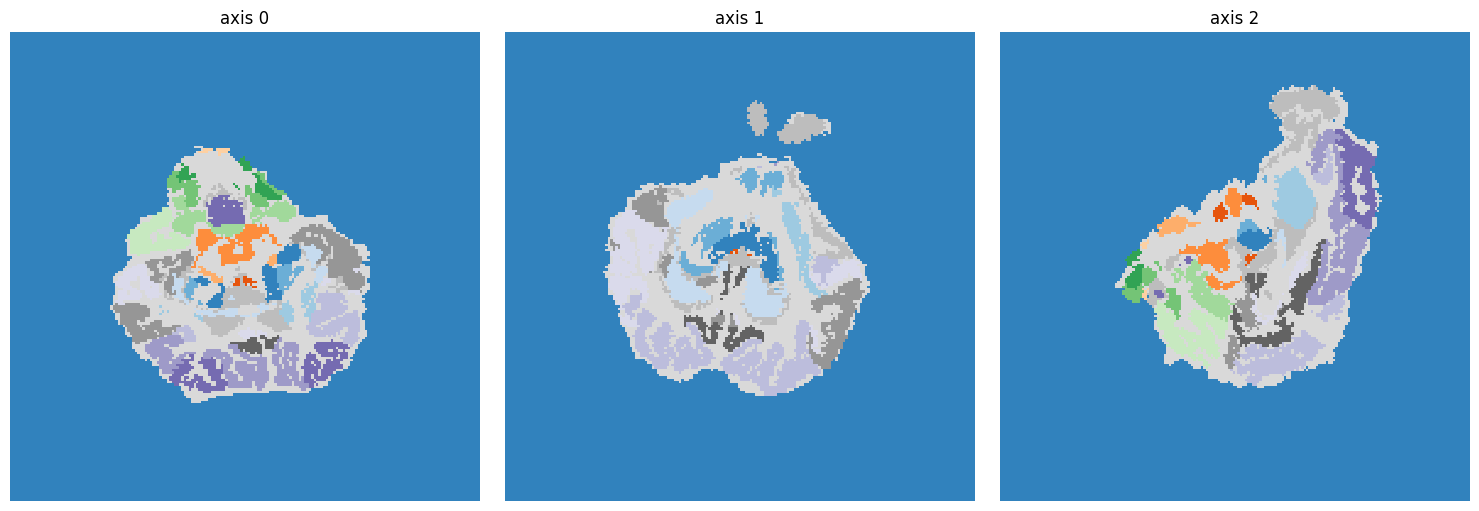

(1, 192, 192, 192, 1)
(192, 192, 192) 38212527 102


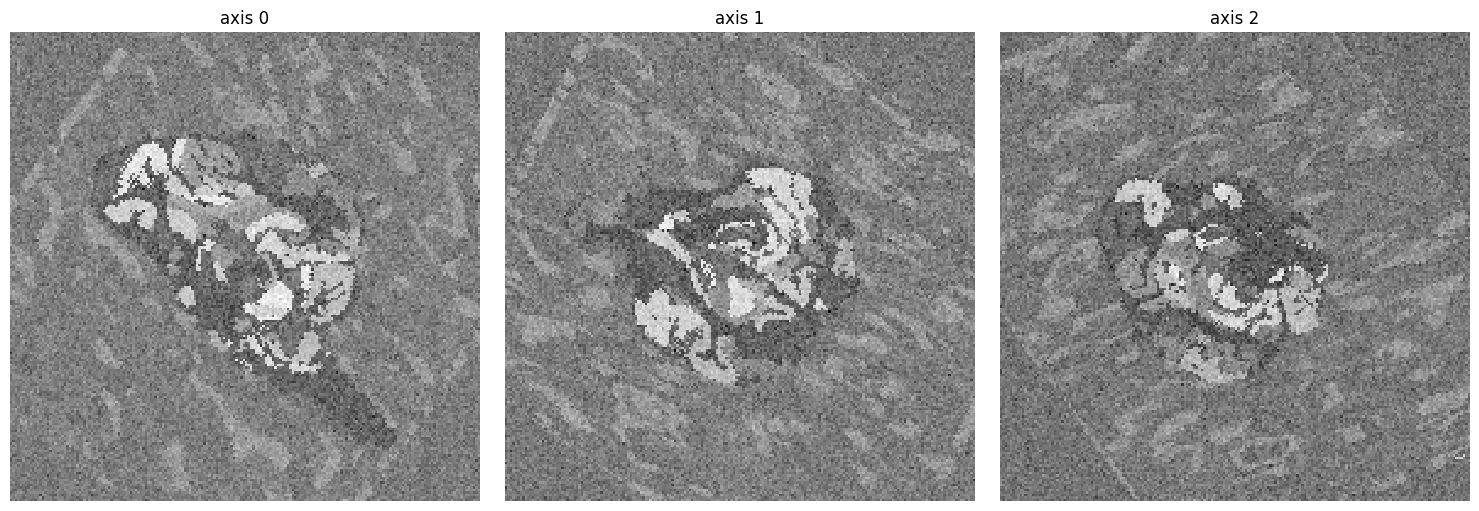

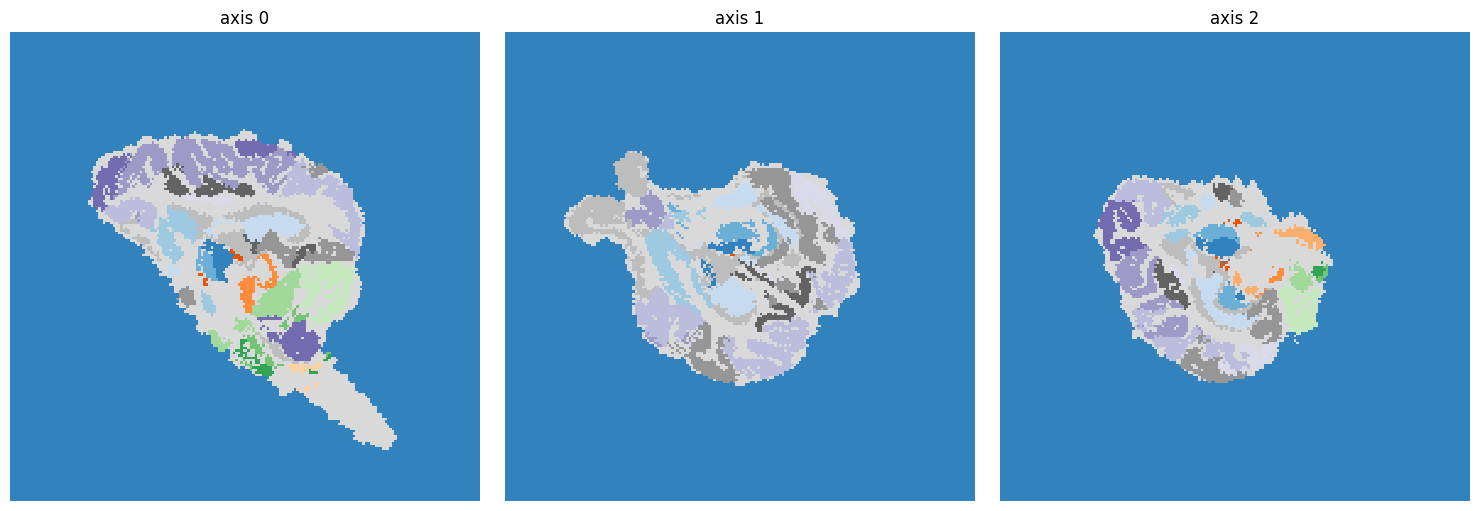

(1, 192, 192, 192, 1)
(192, 192, 192) 44744847 102


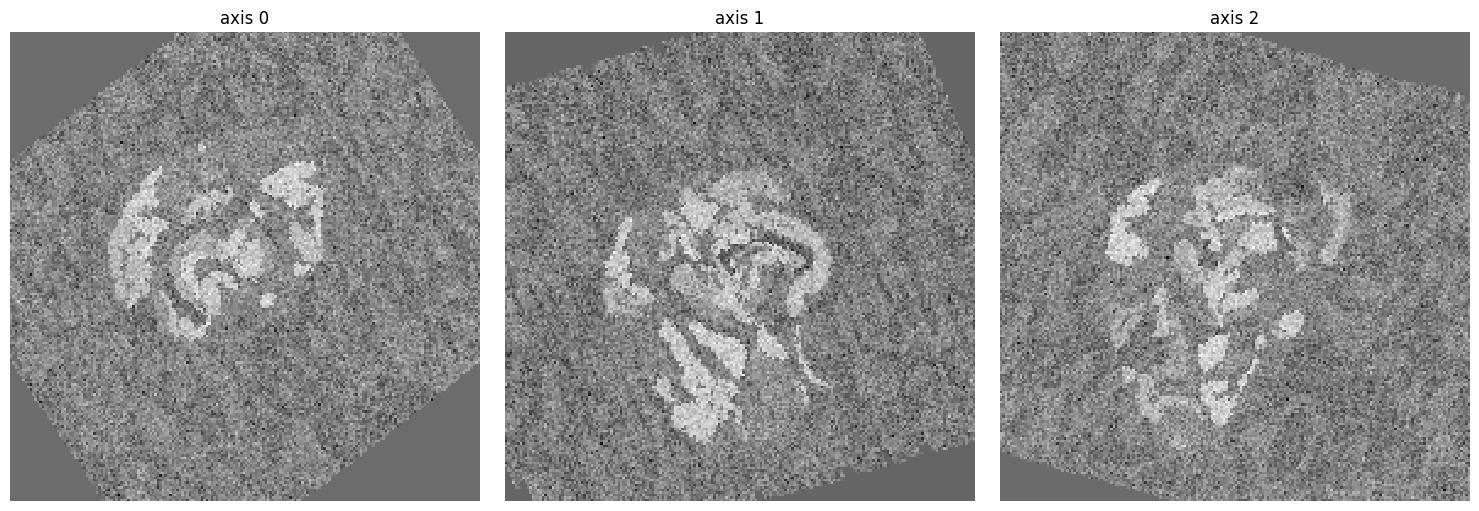

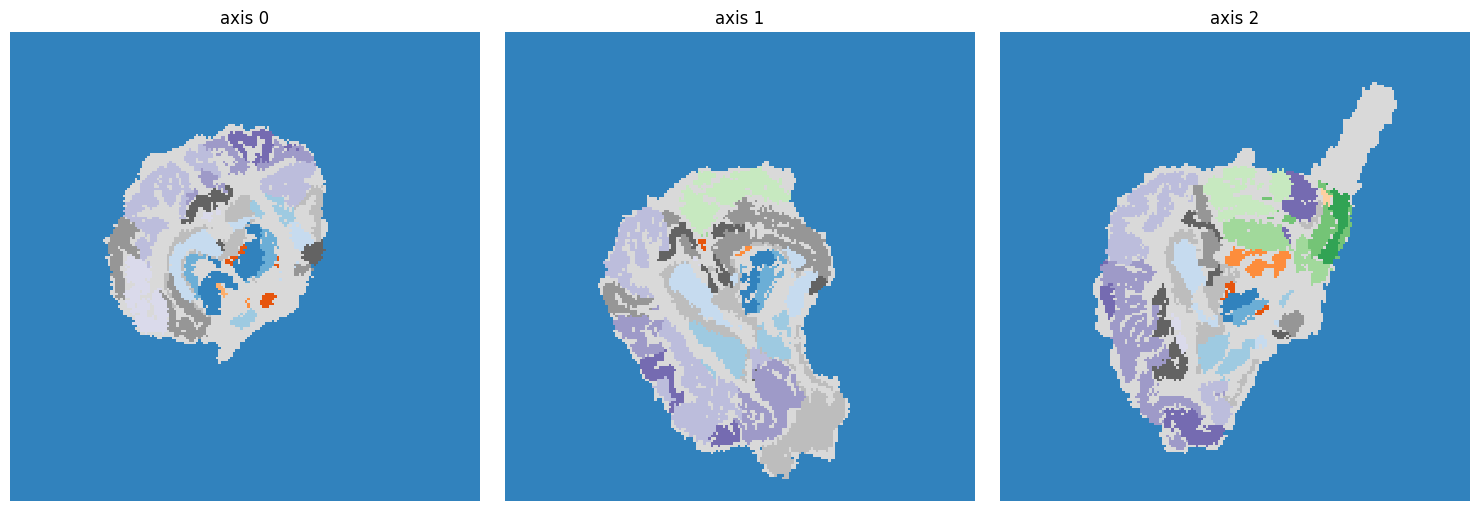

(1, 192, 192, 192, 1)
(192, 192, 192) 45452734 102


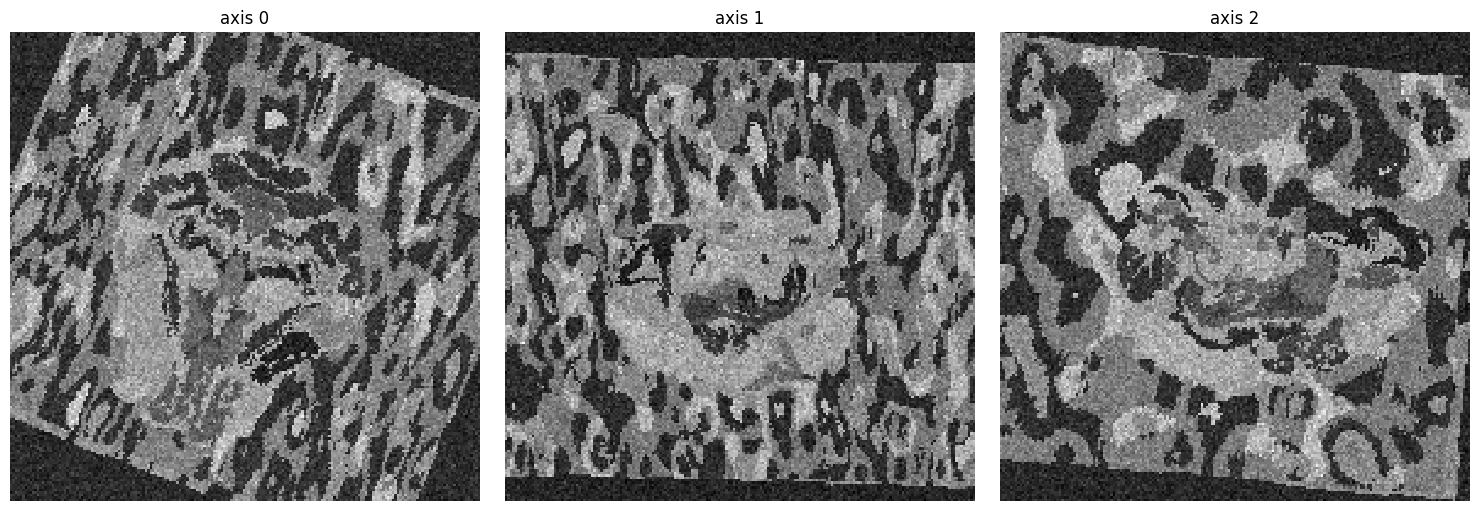

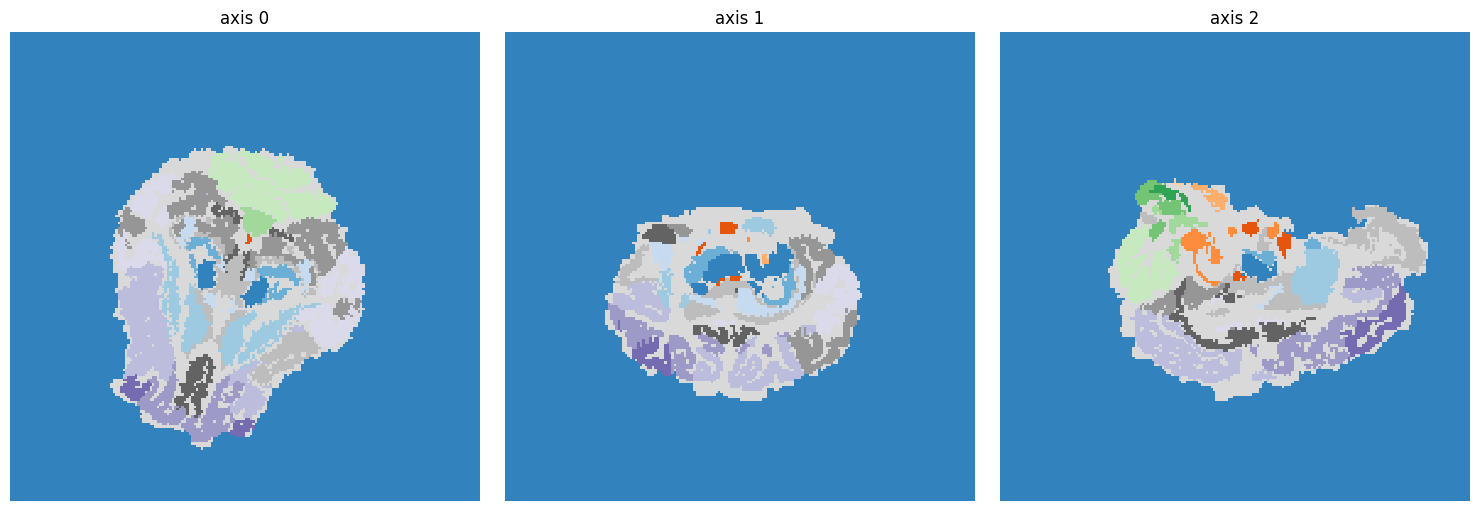

In [29]:
for i in range(5):
    labels_to_image_model = create_model(model3_config)
    generated_img, y = labels_to_image_model(result)
    
    print(generated_img.shape)
    z=np.argmax(y,axis=-1)
    ms = np.mean(np.column_stack(np.nonzero(z[0])), axis=0).astype(int)
    mask = np.argmax(y,axis=-1)[0]
    print(mask.shape,np.sum(mask),np.max(z))
    ne.plot.volume3D(generated_img,slice_nos=ms);
    ne.plot.volume3D(mask,slice_nos=ms,cmaps=['tab20c']);
    nib.save(nib.Nifti1Image(generated_img[0,...,0].numpy(), np.eye(4)),os.path.join("synth_data", str(i)+'_img.nii.gz'))
    nib.save(nib.Nifti1Image(mask.astype(np.int32), np.eye(4)),os.path.join("synth_data", str(i)+'_mask.nii.gz'))

In [ ]:
generated_img[0,...,0].numpy().shape

[DEBUG] NiftiArrayIO.load(): no header extensions found!
[DEBUG] NiftiArrayIO.load(): no header extensions found!
[DEBUG] NiftiArrayIO.load(): no header extensions found!


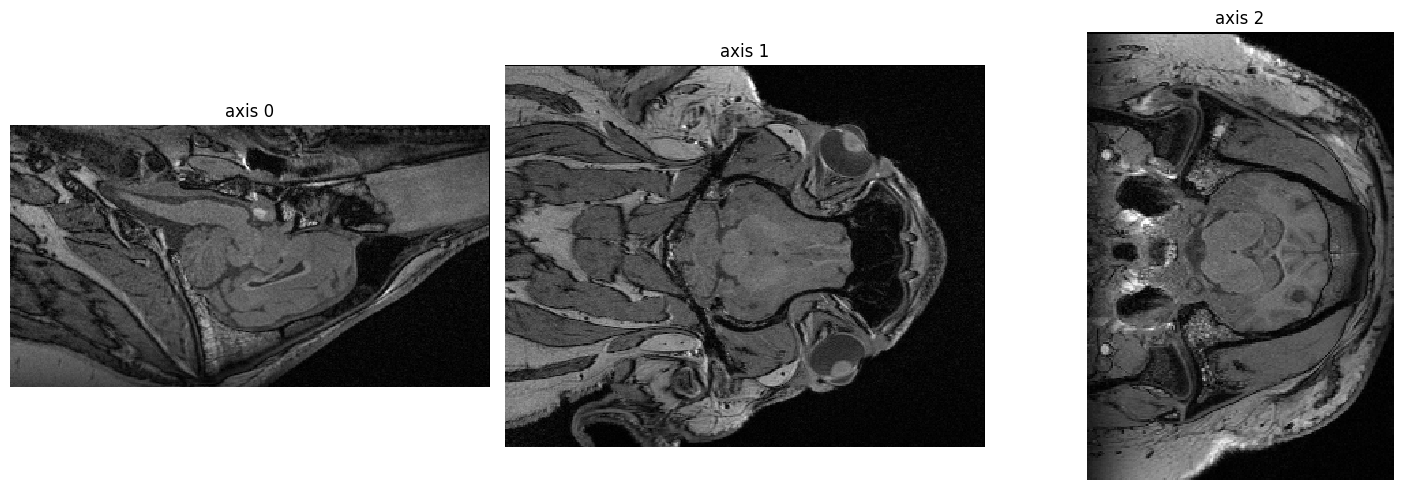

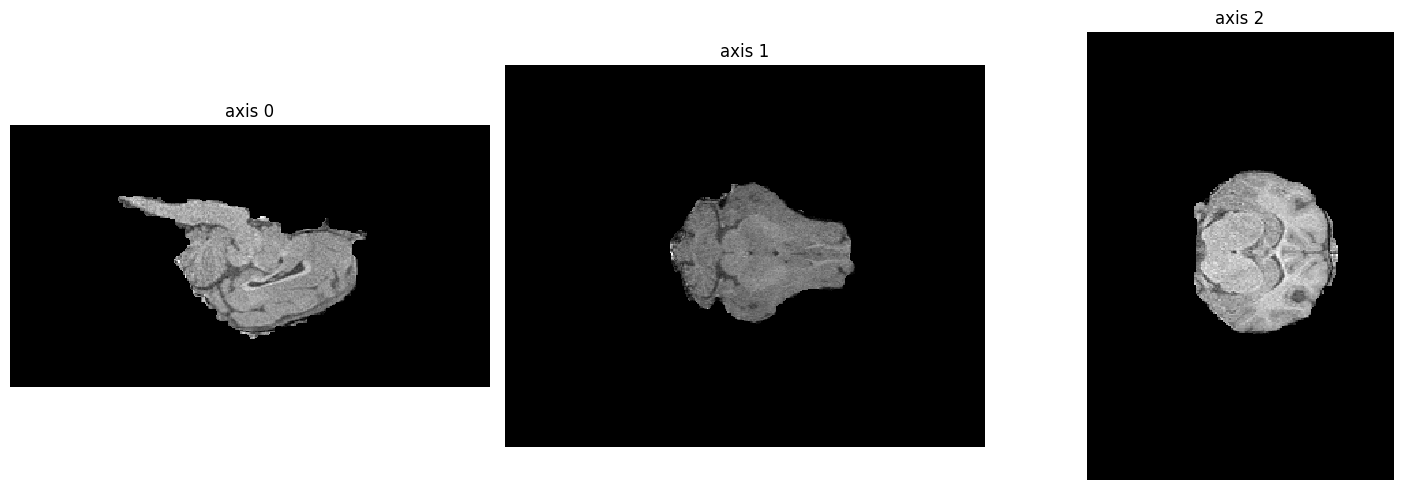

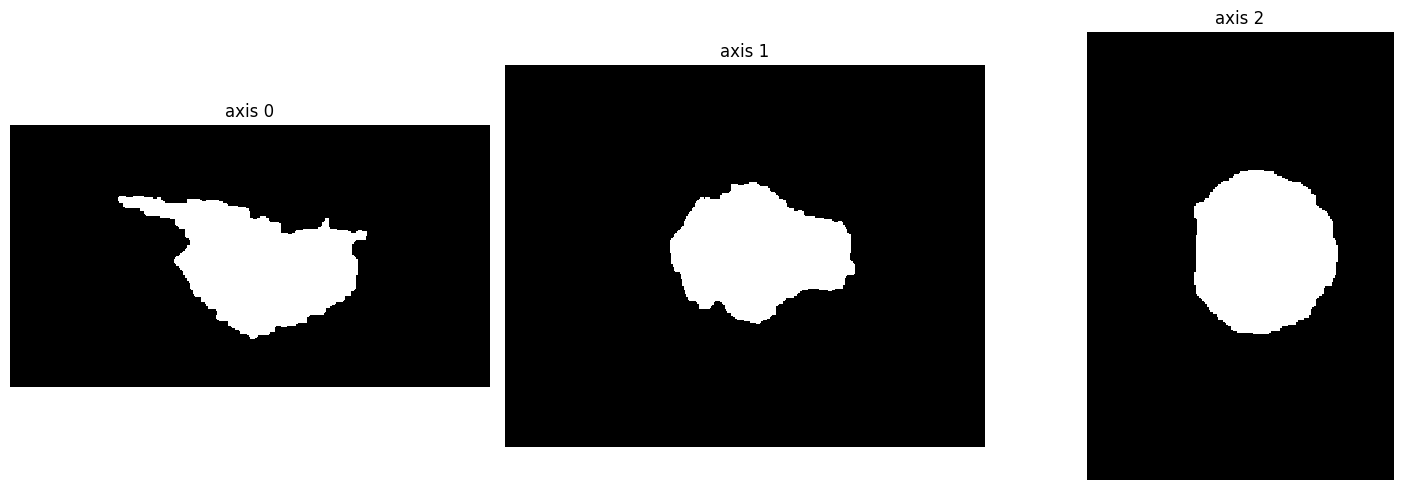

(<Figure size 1500x500 with 3 Axes>,
 [array([<AxesSubplot:title={'center':'axis 0'}>,
         <AxesSubplot:title={'center':'axis 1'}>,
         <AxesSubplot:title={'center':'axis 2'}>], dtype=object)])

In [26]:
from scipy.ndimage import distance_transform_edt
import scipy.ndimage as ndi

folder_path = "/gpfs/fs001/cbica/home/dadashkj/upenn_pigAnatomical/template/"
geom_data = sf.load_volume(os.path.join(folder_path, 'anat.nii.gz')).geom
pig_anat = sf.load_volume(os.path.join(folder_path, 'anat.nii.gz')).data#.reshape([param_3d.img_size_192,]*3).data
 #sf.load_volume(os.path.join(folder_path, 'anat_brain.nii.gz')).reshape([param_3d.img_size_192,]*3).data
pig_brain_mask = sf.load_volume(os.path.join(folder_path, 'anat_brain_mask.nii.gz')).data#.reshape([param_3d.img_size_192,]*3).data
# geom_data=sf.load_volume(os.path.join(folder_path, 'anat_brain_mask.nii.gz')).reshape([param_3d.img_size_192,]*3).geom

# Step 1: Fill Holes Inside the Mask
pig_brain_mask_filled = ndi.binary_fill_holes(pig_brain_mask)

from scipy.ndimage import binary_closing, binary_opening

# Apply morphological closing (fills small holes)
closed_mask = binary_closing(pig_brain_mask_filled, structure=np.ones((3,3,3)))

# Apply morphological opening (removes small protrusions)
pig_brain_mask = binary_opening(closed_mask, structure=np.ones((3,3,3)))


pig_brain = pig_anat * (pig_brain_mask == 1)
ne.plot.volume3D(pig_anat)
ne.plot.volume3D(pig_brain)
ne.plot.volume3D(pig_brain_mask)

In [59]:
# nib.save(nib.Nifti1Image(pig_anat.astype(np.int32), np.array(geom_data.vox2world)),os.path.join(folder_path, 'anat.nii.gz'))
nib.save(nib.Nifti1Image(pig_brain.astype(np.int32), np.eye(4)),os.path.join(folder_path, 'anat_brain.nii.gz'))
# nib.save(nib.Nifti1Image(pig_brain_mask.astype(np.int32), np.array(geom_data.vox2world)),os.path.join(folder_path, 'anat_brain_mask.nii.gz'))

In [21]:
np.array(geom_data.vox2world)

array([[-5.39772749e-01,  0.00000000e+00, -2.64326712e-12,
         7.43575211e+01],
       [ 0.00000000e+00, -5.39999962e-01,  0.00000000e+00,
         6.77581120e+00],
       [-2.64326712e-12,  0.00000000e+00,  5.39772749e-01,
        -9.02229462e+01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [50]:
pig_anat.shape

(192, 192, 192)

In [144]:
predicted_anat_labels=[]

geom_data = sf.load_volume(os.path.join(folder_path, 'anat.nii.gz')).geom
pig_seg = sf.load_volume(os.path.join(folder_path, 'fast_segmentation_seg.nii.gz')).resize(1).reshape([param_3d.img_size_256,]*3).data

pig_anat = sf.load_volume(os.path.join(folder_path, 'anat.nii.gz')).reshape([param_3d.img_size_256,]*3).data
sigma = 1  # Adjust sigma for desired smoothing effect
pig_anat = gaussian_filter(pig_anat, sigma=sigma)

pig_brain_mask = sf.load_volume(os.path.join(folder_path, 'anat_brain_mask.nii.gz')).reshape([param_3d.img_size_256,]*3).data
pig_brain_mask = ndi.binary_fill_holes(pig_brain_mask)
pig_brain = pig_anat * (pig_brain_mask == 1)
scaling_factor = 0.5
pig_anat = sf.Volume(zoom(pig_anat, scaling_factor, order=1)).reshape((256,)*3).data
pig_brain = sf.Volume(zoom(pig_brain, scaling_factor, order=1)).reshape((256,)*3).data
pig_brain_mask = sf.Volume(zoom(pig_brain_mask, scaling_factor, order=1)).reshape((256,)*3).data
pig_brain_mask = ndi.binary_fill_holes(pig_brain_mask)
pig_seg = sf.Volume(zoom(pig_seg, scaling_factor, order=1)).reshape((256,)*3)

pig_skull = np.copy(pig_anat)
pig_skull[pig_brain_mask == 1] = 0
sigma = 1  # Adjust sigma for desired smoothing effect
smoothed_anat = gaussian_filter(pig_anat, sigma=sigma)
brain_data = pig_brain.flatten().reshape(-1, 1)
non_brain_data = pig_skull.flatten().reshape(-1, 1)

def make_smooth(label_map):
    smoothed_labels = gaussian_filter(label_map.astype(float), sigma=1)
    return np.round(smoothed_labels).astype(int)
    
# Apply GMM for brain regions (assumes 29 brain regions to be classified)
gmm_brain = GaussianMixture(n_components=k1, random_state=42)
gmm_brain.fit(brain_data)  # Fit GMM on the brain data

# Apply GMM for non-brain regions (background and other tissues)
gmm_non_brain = GaussianMixture(n_components=k2, random_state=42)  # 0 for background, 30-40 for other tissues
gmm_non_brain.fit(non_brain_data)  # Fit GMM on the non-brain data

# Predict the components (labels) for brain and non-brain regions
predicted_brain_labels = gmm_brain.predict(brain_data)

if k1==0:
    predicted_brain_labels = pig_seg
    
predicted_non_brain_labels = gmm_non_brain.predict(non_brain_data)

predicted_brain_labels = make_smooth(predicted_brain_labels)
predicted_non_brain_labels = make_smooth(predicted_non_brain_labels)


predicted_brain_labels = predicted_brain_labels.reshape((256,256,256))
predicted_non_brain_labels = predicted_non_brain_labels.reshape((256,256,256))

predicted_non_brain_labels[pig_brain_mask == 1] = 0
predicted_non_brain_labels = shift_non_zero_elements(predicted_non_brain_labels,6)
predicted_anat_label = np.where(predicted_brain_labels > 0, predicted_brain_labels, predicted_non_brain_labels)

zoomed_predicted_anat_labels = sf.Volume(predicted_anat_label).reshape([param_3d.img_size_192,]*3)
predicted_anat_labels.append(zoomed_predicted_anat_labels)

with open("params_gmm_192.json", "r") as json_file:
    config = json.load(json_file)
# pig_brain_map = [predicted_anat_labels]
gen=generator_brain_window_Net(predicted_anat_labels,param_3d.img_size_192)



model_pig_config = config["pig_48"]
model_shapes_config = config["shapes"]
model3_config = config["labels_to_image_model_48"]
model3_config["labels_out"] = {int(key): value for key, value in model3_config["labels_out"].items()}
model3_config["in_shape"]=[ param_3d.img_size_192, param_3d.img_size_192, param_3d.img_size_192]
model_pig_config["in_shape"]=[ param_3d.img_size_192, param_3d.img_size_192, param_3d.img_size_192]
model_shapes_config["in_shape"]=[ param_3d.img_size_192, param_3d.img_size_192, param_3d.img_size_192]

model_pig = create_model(model_pig_config)
model_shapes = create_model(model_shapes_config)

labels_to_image_model = create_model(model3_config)

fragment = next(gen)
# _, fg = model_pig(fragment)


[DEBUG] NiftiArrayIO.load(): no header extensions found!
[DEBUG] NiftiArrayIO.load(): no header extensions found!
[DEBUG] NiftiArrayIO.load(): no header extensions found!
[DEBUG] NiftiArrayIO.load(): no header extensions found!


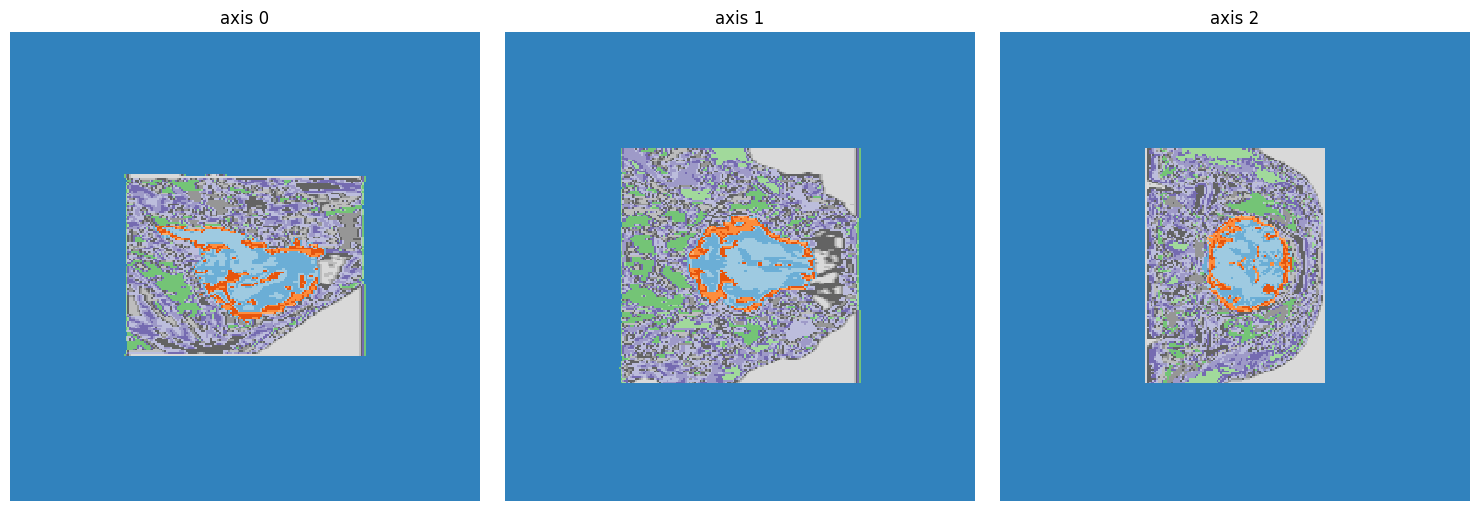

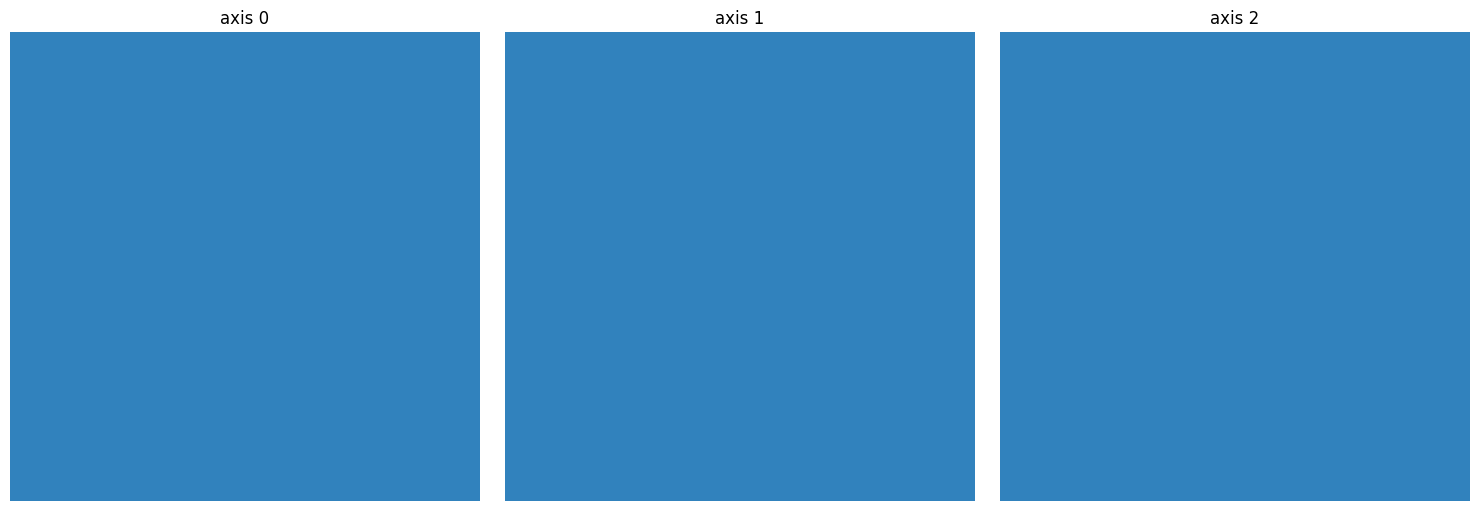

[ 0  1  2  3  4  5  7  8  9 10 11 12 13 14 15]


In [139]:
ne.plot.volume3D(predicted_anat_label,cmaps=['tab20c'])
ne.plot.volume3D(predicted_anat_labels[0],cmaps=['tab20c'])

print(np.unique(predicted_anat_label))

In [143]:
np.sum(predicted_anat_labels)

0.0

In [44]:
import numpy as np
from scipy.ndimage import gaussian_filter, binary_dilation
from skimage.draw import ellipsoid
from skimage.util import random_noise

import numpy as np
from scipy.ndimage import gaussian_filter, binary_dilation, binary_erosion
from skimage.util import random_noise

import numpy as np
from scipy.ndimage import binary_dilation

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from scipy.interpolate import splprep, splev

import numpy as np
from scipy.interpolate import splprep, splev
from scipy.ndimage import gaussian_filter

import numpy as np
from scipy.interpolate import splprep, splev
from scipy.ndimage import gaussian_filter

import numpy as np
from scipy.interpolate import splprep, splev
from scipy.ndimage import gaussian_filter

import tensorflow as tf
import numpy as np
from scipy.interpolate import splprep, splev
from scipy.ndimage import gaussian_filter

def generate_single_streamline(shape, max_length, thickness_range):
    start = np.random.randint(0, shape[0], size=3)
    num_ctrl_pts = np.random.randint(5, 10)
    ctrl_pts = np.zeros((3, num_ctrl_pts))

    for i in range(3):
        noise = np.cumsum(np.random.randn(num_ctrl_pts) * 5)
        ctrl_pts[i] = np.clip(start[i] + noise, 0, shape[i] - 1)

    try:
        tck, _ = splprep(ctrl_pts, s=0)
        u = np.linspace(0, 1, max_length)
        x, y, z = splev(u, tck)
    except:
        return None, None

    coords = np.stack([x, y, z], axis=-1).astype(np.int32)
    label = np.random.randint(1, 11)
    return coords, label

def generate_3d_vessel_label_map_tf(
    shape=(256, 256, 256),
    num_streamlines=1000,
    max_length=180,
    thickness_range=(1, 2),
    smooth_sigma=0.0,
    seed=42
):
    np.random.seed(seed)
    volume = np.zeros(shape, dtype=np.uint8)

    for _ in range(num_streamlines):
        coords, label = generate_single_streamline(shape, max_length, thickness_range)
        if coords is None:
            continue

        for xi, yi, zi in coords:
            if 0 <= xi < shape[0] and 0 <= yi < shape[1] and 0 <= zi < shape[2]:
                r = np.random.randint(*thickness_range)
                xs = slice(max(0, xi - r), min(shape[0], xi + r + 1))
                ys = slice(max(0, yi - r), min(shape[1], yi + r + 1))
                zs = slice(max(0, zi - r), min(shape[2], zi + r + 1))
                volume[xs, ys, zs] = label

    if smooth_sigma > 0:
        blurred = gaussian_filter(volume.astype(np.float32), sigma=smooth_sigma)
        volume = (blurred > 0.2).astype(np.uint8)

    return tf.convert_to_tensor(volume)






streamline = generate_3d_vessel_label_map_tf()



2025-04-30 18:23:38.690082: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11419 MB memory:  -> device: 0, name: TITAN Xp COLLECTORS EDITION, pci bus id: 0000:04:00.0, compute capability: 6.1


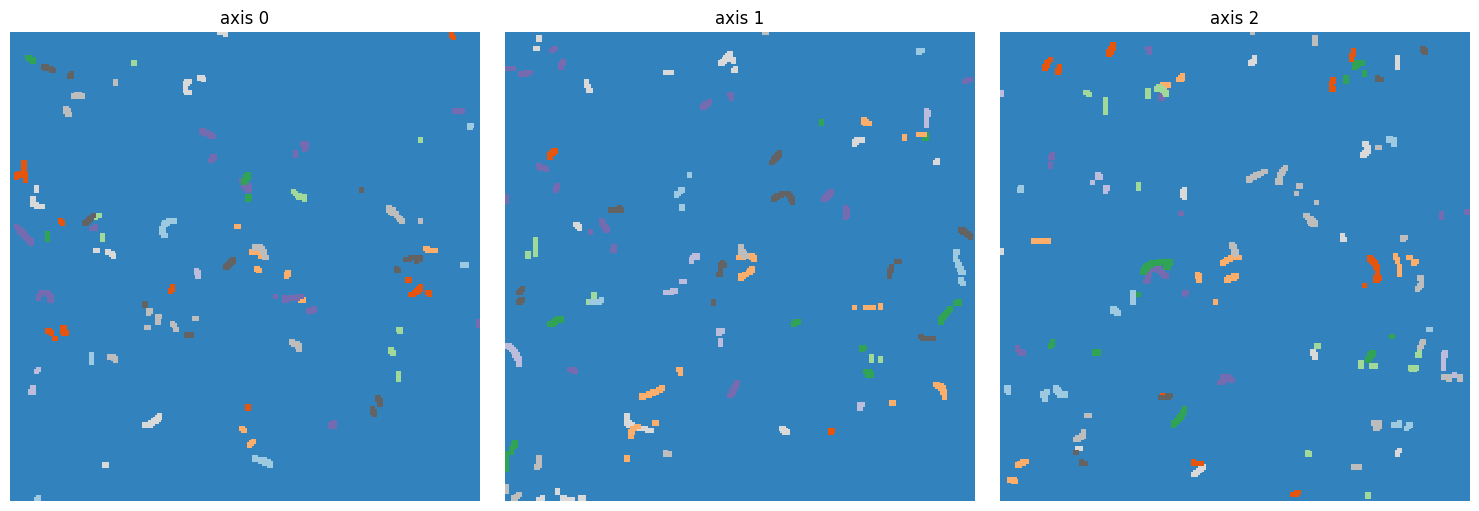

In [47]:
ne.plot.volume3D(streamline,cmaps=['tab20c'])
nib.save(nib.Nifti1Image(streamline.numpy().astype(np.int32), np.eye(4)), os.path.join("synth_data", 'streamline.nii.gz'))


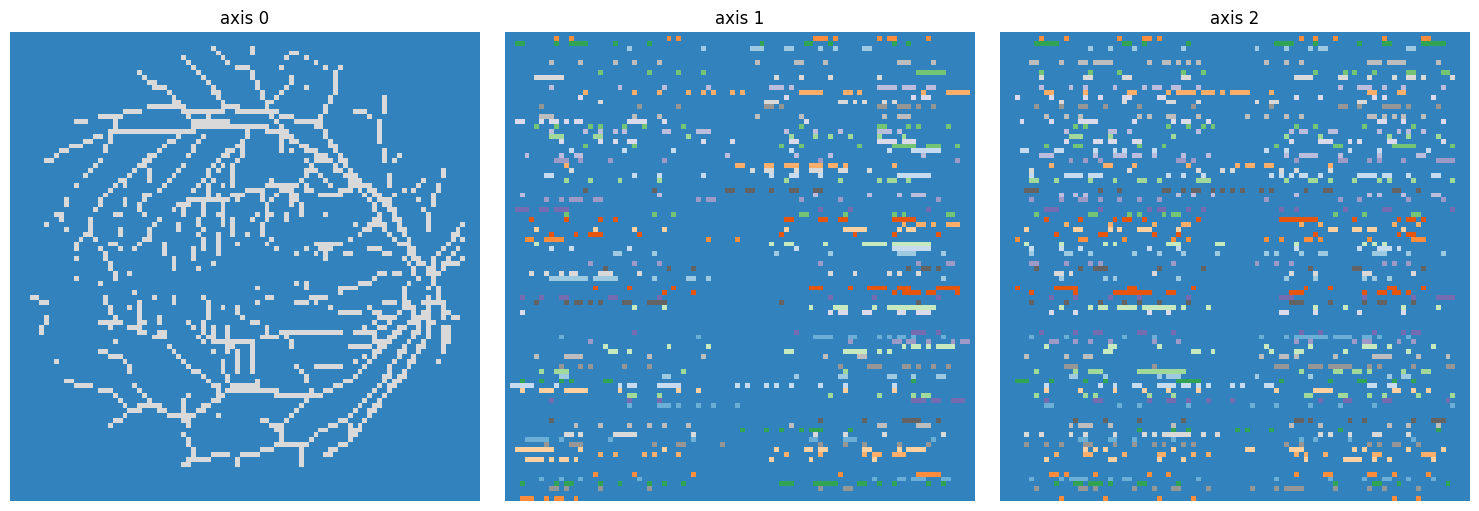

In [106]:
np.unique(combined_map)

array([0, 1, 4, 5, 7, 9], dtype=int32)

In [93]:
np.unique(combined_map)

array([ 1,  2,  3,  5,  6,  7,  8, 10, 11, 12, 15, 16], dtype=int32)

In [78]:
np.unique(anatomy)

array([0, 1], dtype=int32)

In [79]:
np.shape(anatomy)

TensorShape([96, 96, 96])

In [90]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("abdallahwagih/retina-blood-vessel")

print("Path to dataset files:", path)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 32.9M/32.9M [00:00<00:00, 44.3MB/s]

Extracting model files...


Path to dataset files: /cbica/home/dadashkj/.cache/kagglehub/datasets/abdallahwagih/retina-blood-vessel/versions/1
